**Лабораторна робота №1**

Виконала студентка групи КНСШ-12

Вільчинська Оксана-Олеся


**Завдання 2**

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [4]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from keras.models import Sequential
from keras.layers import Dense, Input
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from tabulate import tabulate
import seaborn as sns
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score
#read in data using pandas
train_df = pd.read_csv("/content/gdrive/My Drive/Colab Notebooks/Deep Learning/Task 1/diabetes_data.csv")

#check data has been read in properly
train_df.head()

,pregnancies,glucose,diastolic,triceps,insulin,bmi,dpf,age,diabetes
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [5]:
train_df.describe()

,pregnancies,glucose,diastolic,triceps,insulin,bmi,dpf,age,diabetes
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [6]:
# create a dataframe with all training data except the target column
data_X = train_df.drop(columns=['diabetes'])
data_Y = train_df['diabetes']
#check that the target variable has been removed
data_X.head()

,pregnancies,glucose,diastolic,triceps,insulin,bmi,dpf,age
0,6,148,72,35,0,33.6,0.627,50
1,1,85,66,29,0,26.6,0.351,31
2,8,183,64,0,0,23.3,0.672,32
3,1,89,66,23,94,28.1,0.167,21
4,0,137,40,35,168,43.1,2.288,33


# Оновлена модель

In [11]:
from keras.models import Sequential
from keras.layers import Dense, Input
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

results = []
class DiabetesPredictionModel:
    def __init__(self, architecture=None, activation='relu', optimizer='adam', batch_size=64, epochs=10):
        self.architecture = architecture or [64, 32, 16]
        self.activation = activation
        self.optimizer = optimizer
        self.batch_size = batch_size
        self.epochs = epochs
        self.model = None

    def build_model(self, input_shape):
        model = Sequential()
        model.add(Input(shape=(input_shape,)))

        # Add hidden layers dynamically based on the architecture
        for layer_size in self.architecture:
            model.add(Dense(layer_size, activation=self.activation))

        # Output layer
        model.add(Dense(2, activation='softmax'))

        # Compile the model
        model.compile(optimizer=self.optimizer,
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])

        self.model = model

    def plot_visualization(self, history):
        # Visualize the training and validation loss
        plt.plot(history.history['loss'], label='Training loss')
        plt.plot(history.history['val_loss'], label='Validation loss')
        plt.title('Training and Validation Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()
        plt.plot(history.history['accuracy'], label = 'Training accuracy')
        plt.plot(history.history['val_accuracy'], label = 'Validation accuracy')
        plt.title("Training and Validation Accuracy")
        plt.xlabel("Number of Epochs")
        plt.ylabel("Accuracy")
        plt.legend()
        plt.show()
        #print('Max val acc', np.max(h.history['val_accuracy']))

    def train_model(self, train_X, train_Y):
        early_stopping_monitor = EarlyStopping(patience=4)

        history = self.model.fit(
            train_X, train_Y,
            validation_split=0.2,
            batch_size=self.batch_size,
            epochs=self.epochs,
            callbacks=[early_stopping_monitor]
        )

        return history

    def evaluate_model(self, X_test, Y_test):
        test_loss, test_accuracy = self.model.evaluate(X_test, Y_test)
        return test_loss, test_accuracy

    def calculate_metrics(self, X_test, Y_test):
        # Predict the test data
        Y_pred = self.model.predict(X_test)
        Y_pred_classes = Y_pred.argmax(axis=1)  # Get the predicted class labels
        Y_true = Y_test.argmax(axis=1)  # Convert one-hot encoded labels back to classes

        precision = precision_score(Y_true, Y_pred_classes, average='weighted')
        recall = recall_score(Y_true, Y_pred_classes, average='weighted')
        f1 = f1_score(Y_true, Y_pred_classes, average='weighted')

        return precision, recall, f1

    def confusion_matrix_visualization(self, X_test, Y_test, title):
        Y_pred = self.model.predict(X_test)
        Y_pred_classes = Y_pred.argmax(axis=1)  # Get the predicted class labels
        Y_true = Y_test.argmax(axis=1)  # Convert one-hot encoded labels back to classes

        # compute the confusion matrix
        confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)
        f,ax = plt.subplots(figsize=(11, 11))
        plt.title(title)
        sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="Greens",linecolor="gray", fmt= '.1f',ax=ax)
        plt.xlabel("Predicted Label")
        plt.ylabel("True Label")
        plt.title("Confusion Matrix")
        plt.show()

    def save_results(self, history, test_loss, test_accuracy, precision, recall, f1):
        train_loss = history.history['loss'][-1]
        val_loss = history.history['val_loss'][-1]
        results.append([
            self.architecture, self.activation, self.batch_size,
            float(self.model.optimizer.learning_rate.numpy()), self.optimizer,
            self.epochs, train_loss, val_loss, test_loss, test_accuracy,
            precision, recall, f1
        ])

        return val_loss

    def run(self, train_X, train_Y, X_test, Y_test):
        input_shape = train_X.shape[1]
        self.build_model(input_shape)

        history = self.train_model(train_X, train_Y)
        self.plot_visualization(history)

        test_loss, test_accuracy = self.evaluate_model(X_test, Y_test)
        precision, recall, f1 = self.calculate_metrics(X_test, Y_test)

        val_loss = self.save_results(history, test_loss, test_accuracy, precision, recall, f1)

        print(f"Test Accuracy: {test_accuracy}, Precision: {precision}, Recall: {recall}, F1 Score: {f1}")
        return test_loss, val_loss, test_accuracy, precision, recall, f1


#model_instance = DiabetesPredictionModel()
#base_model = model_instance.run(train_X, train_Y, X_test, Y_test)


# Нормалізація даних

In [13]:
from keras.utils import to_categorical
#one-hot encode target column
train_one_hot = to_categorical(data_Y)
#vcheck that target column has been converted train_y_2[0:5]
train_one_hot

array([[0., 1.],
       [1., 0.],
       [0., 1.],
       ...,
       [1., 0.],
       [0., 1.],
       [1., 0.]])

In [14]:
'''# Перевіримо на пропущені значення
missing_data = data_X.isnull().sum()

# Заповнимо нульові значення (наприклад, нулі в інсуліні) середніми значеннями
data_X['insulin'] = data_X['insulin'].replace(0, data_X['insulin'].mean())
data_X['bmi'] = data_X['bmi'].replace(0, data_X['bmi'].mean())
data_X['glucose'] = data_X['glucose'].replace(0, data_X['glucose'].mean())
data_X['diastolic'] = data_X['diastolic'].replace(0, data_X['diastolic'].mean())'''


"# Перевіримо на пропущені значення\nmissing_data = data_X.isnull().sum()\n\n# Заповнимо нульові значення (наприклад, нулі в інсуліні) середніми значеннями\ndata_X['insulin'] = data_X['insulin'].replace(0, data_X['insulin'].mean())\ndata_X['bmi'] = data_X['bmi'].replace(0, data_X['bmi'].mean())\ndata_X['glucose'] = data_X['glucose'].replace(0, data_X['glucose'].mean())\ndata_X['diastolic'] = data_X['diastolic'].replace(0, data_X['diastolic'].mean())"

In [15]:
def split_data(data_X, data_Y):
  # Train/validation/test split(70% train, 20% validation, 10% test)
  return train_test_split(data_X, data_Y, test_size=0.1, random_state=52)

## Без скейлінгу

Epoch 1/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.3890 - loss: 12.8094 - val_accuracy: 0.6978 - val_loss: 3.6303
Epoch 2/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6530 - loss: 4.3735 - val_accuracy: 0.6763 - val_loss: 1.4894
Epoch 3/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5611 - loss: 1.8286 - val_accuracy: 0.5899 - val_loss: 1.3252
Epoch 4/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6414 - loss: 1.2287 - val_accuracy: 0.6835 - val_loss: 0.8571
Epoch 5/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5681 - loss: 1.0353 - val_accuracy: 0.6978 - val_loss: 0.6751
Epoch 6/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6441 - loss: 0.8285 - val_accuracy: 0.6331 - val_loss: 0.7747
Epoch 7/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6542 - loss: 0.6665 - val_accuracy: 0.6403 - val_loss: 0.7912
Epoch 8/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6374 - loss: 0.7242 - val_accuracy: 0.6763 - val_loss: 0.6809
Epoch 

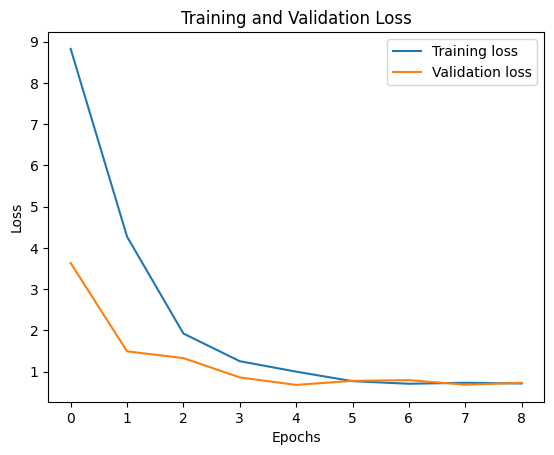

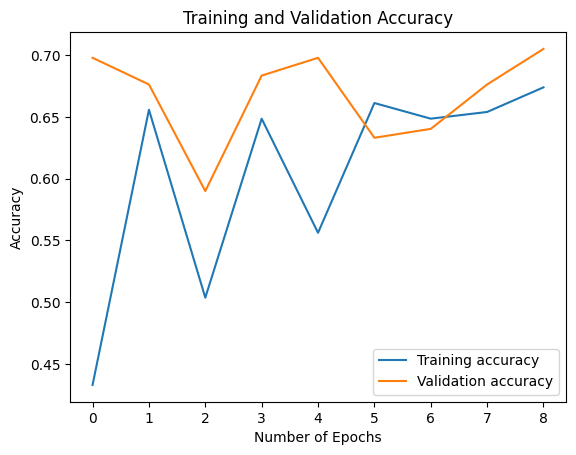

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6814 - loss: 0.7234 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Test Accuracy: 0.7142857313156128, Precision: 0.737313432835821, Recall: 0.7142857142857143, F1 Score: 0.6687840290381125


In [16]:
train_X, X_test, train_Y, Y_test = split_data(data_X, train_one_hot)
model_instance = DiabetesPredictionModel()
base_model = model_instance.run(train_X, train_Y, X_test, Y_test)

## Minmax

In [17]:
minmax = MinMaxScaler()
X_minmax = minmax.fit_transform(data_X)
X_minmax

array([[0.35294118, 0.74371859, 0.59016393, ..., 0.50074516, 0.23441503,
        0.48333333],
       [0.05882353, 0.42713568, 0.54098361, ..., 0.39642325, 0.11656704,
        0.16666667],
       [0.47058824, 0.91959799, 0.52459016, ..., 0.34724292, 0.25362938,
        0.18333333],
       ...,
       [0.29411765, 0.6080402 , 0.59016393, ..., 0.390462  , 0.07130658,
        0.15      ],
       [0.05882353, 0.63316583, 0.49180328, ..., 0.4485842 , 0.11571307,
        0.43333333],
       [0.05882353, 0.46733668, 0.57377049, ..., 0.45305514, 0.10119556,
        0.03333333]])

Epoch 1/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.6395 - loss: 0.6776 - val_accuracy: 0.6835 - val_loss: 0.6536
Epoch 2/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6480 - loss: 0.6658 - val_accuracy: 0.6835 - val_loss: 0.6431
Epoch 3/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6519 - loss: 0.6533 - val_accuracy: 0.6835 - val_loss: 0.6364
Epoch 4/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6631 - loss: 0.6412 - val_accuracy: 0.6835 - val_loss: 0.6334
Epoch 5/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6555 - loss: 0.6394 - val_accuracy: 0.6835 - val_loss: 0.6323
Epoch 6/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6201 - loss: 0.6410 - val_accuracy: 0.6906 - val_loss: 0.6225
Epoch 7/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6482 - loss: 0.6188 - val_accuracy: 0.6835 - val_loss: 0.6148
Epoch 8/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6703 - loss: 0.6144 - val_accuracy: 0.6763 - val_loss: 0.6086
Epoc

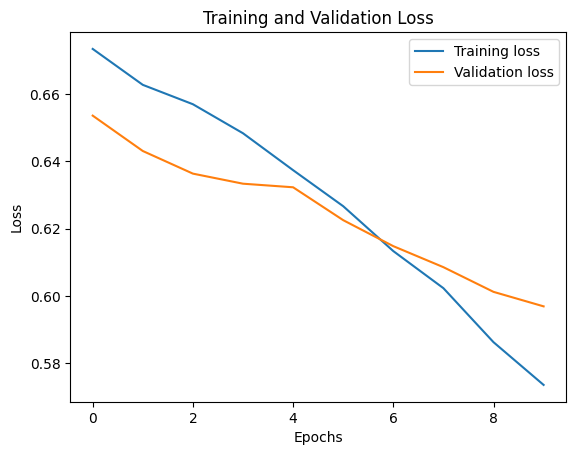

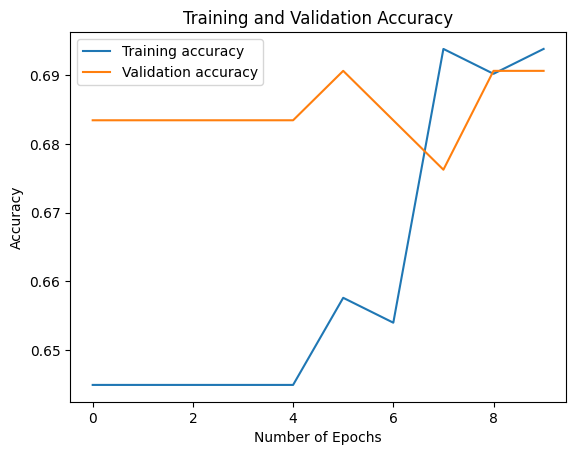

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6892 - loss: 0.6075 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Test Accuracy: 0.7142857313156128, Precision: 0.7062146892655367, Recall: 0.7142857142857143, F1 Score: 0.6964573268921095


In [18]:
train_X, X_test, train_Y, Y_test = split_data(X_minmax, train_one_hot)
model_instance = DiabetesPredictionModel()
base_model = model_instance.run(train_X, train_Y, X_test, Y_test)

## StandardScaler

In [19]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(data_X)
X_scaled

array([[ 0.63994726,  0.84832379,  0.14964075, ...,  0.20401277,
         0.46849198,  1.4259954 ],
       [-0.84488505, -1.12339636, -0.16054575, ..., -0.68442195,
        -0.36506078, -0.19067191],
       [ 1.23388019,  1.94372388, -0.26394125, ..., -1.10325546,
         0.60439732, -0.10558415],
       ...,
       [ 0.3429808 ,  0.00330087,  0.14964075, ..., -0.73518964,
        -0.68519336, -0.27575966],
       [-0.84488505,  0.1597866 , -0.47073225, ..., -0.24020459,
        -0.37110101,  1.17073215],
       [-0.84488505, -0.8730192 ,  0.04624525, ..., -0.20212881,
        -0.47378505, -0.87137393]])

Epoch 1/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.4657 - loss: 0.7099 - val_accuracy: 0.7338 - val_loss: 0.6486
Epoch 2/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6823 - loss: 0.6392 - val_accuracy: 0.7554 - val_loss: 0.6005
Epoch 3/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7337 - loss: 0.5913 - val_accuracy: 0.7626 - val_loss: 0.5555
Epoch 4/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7576 - loss: 0.5449 - val_accuracy: 0.7626 - val_loss: 0.5193
Epoch 5/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7802 - loss: 0.4990 - val_accuracy: 0.7626 - val_loss: 0.4911
Epoch 6/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7900 - loss: 0.4817 - val_accuracy: 0.7842 - val_loss: 0.4761
Epoch 7/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7800 - loss: 0.4712 - val_accuracy: 0.7842 - val_loss: 0.4683
Epoch 8/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7796 - loss: 0.4624 - val_accuracy: 0.7842 - val_loss: 0.4644
Epoch 9

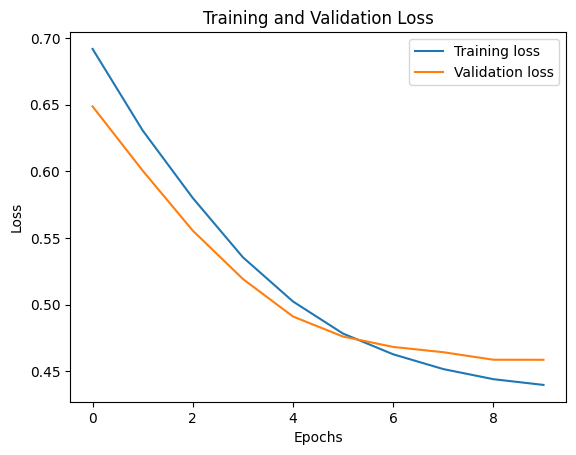

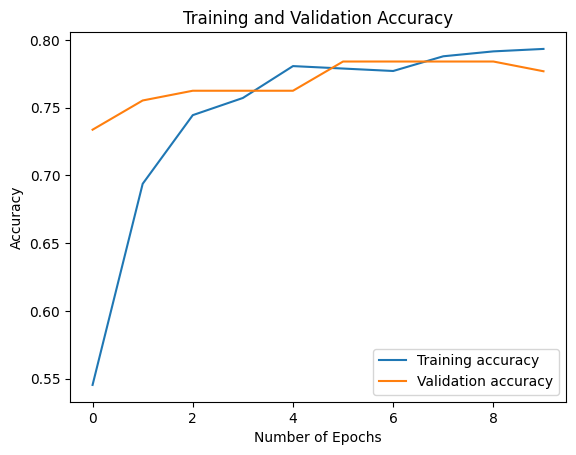

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6839 - loss: 0.5915 


1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Test Accuracy: 0.7272727489471436, Precision: 0.7222377622377623, Recall: 0.7272727272727273, F1 Score: 0.7236044359152897
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


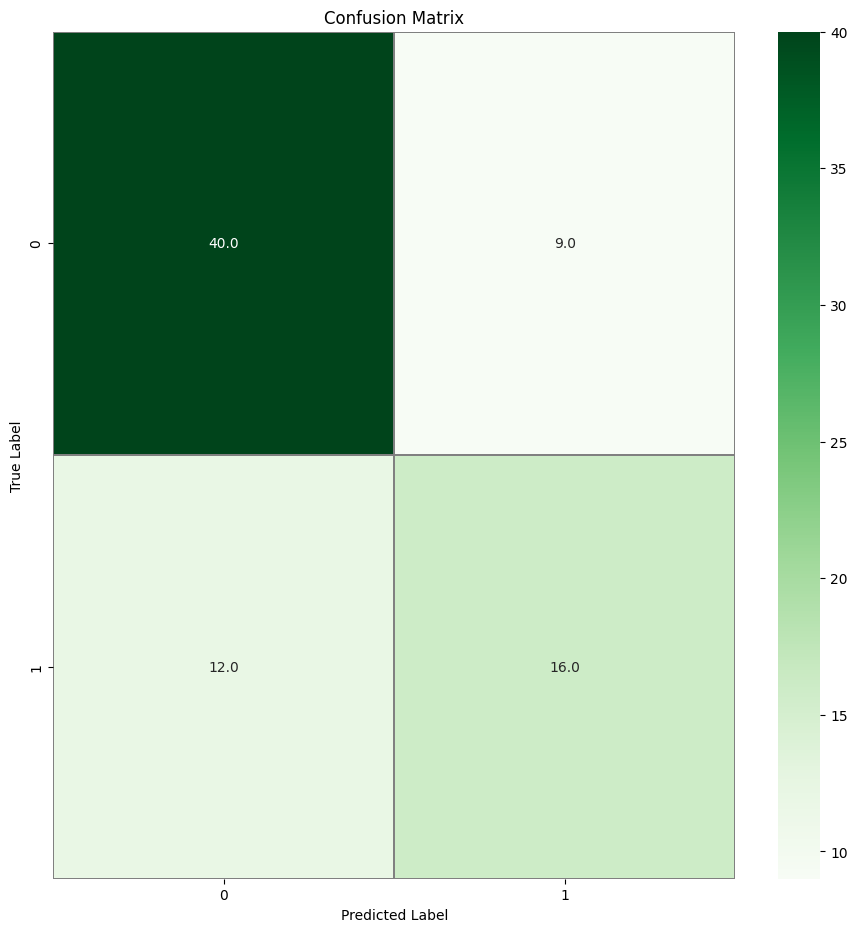

In [20]:
train_X, X_test, train_Y, Y_test = split_data(X_scaled, train_one_hot)
model_instance = DiabetesPredictionModel()
base_model = model_instance.run(train_X, train_Y, X_test, Y_test)
model_instance.confusion_matrix_visualization(X_test, Y_test, "Confusion Matrix with StandardScaler data")

# plot_results

In [21]:
def plot_results(results: dict, columns: str):
  df = pd.DataFrame(results).T.reset_index().rename(columns={'index':  columns})
  df_melted = df.melt(id_vars=[columns],
  value_vars=['loss','val_loss'],
  var_name='Metric', value_name='Value')
  plt.figure(figsize=(14, 7))
  sns.barplot(x=columns, y='Value', hue='Metric', data=df_melted)
  plt.title('Comparison of Loss and Validation Loss')
  plt.ylabel('Value')
  plt.xlabel(columns)
  plt.legend(title='Metric')
  df_melted = df.melt(id_vars=[columns], value_vars=['accuracy'],
  var_name='Metric', value_name='Value')
  plt.figure(figsize=(14, 7))
  sns.barplot(x=columns, y='Value', hue='Metric', data=df_melted)
  plt.title('Comparison of accuracy')
  plt.ylabel('Value')
  plt.xlabel(columns)
  plt.legend(title='Metric')
  plt.show()

In [22]:
def summarize_results(results):
    print(tabulate(
        results,
        headers=['architecture', 'activation', 'batch_size', 'lr',
                  'optimizer', 'epochs', 'train_loss', 'val_loss', 'test_loss', 'accuracy', 'precision', 'recall', 'f1_score'],
        tablefmt="grid",
        showindex="always"
    ))

In [23]:
summarize_results(results)

+----+----------------+--------------+--------------+-------+-------------+----------+--------------+------------+-------------+------------+-------------+----------+------------+
|    | architecture   | activation   |   batch_size |    lr | optimizer   |   epochs |   train_loss |   val_loss |   test_loss |   accuracy |   precision |   recall |   f1_score |
+====+================+==============+==============+=======+=============+==========+==============+============+=============+============+=============+==========+============+
|  0 | [64, 32, 16]   | relu         |           64 | 0.001 | adam        |       10 |     0.709481 |   0.726069 |    0.70119  |   0.714286 |    0.737313 | 0.714286 |   0.668784 |
+----+----------------+--------------+--------------+-------+-------------+----------+--------------+------------+-------------+------------+-------------+----------+------------+
|  1 | [64, 32, 16]   | relu         |           64 | 0.001 | adam        |       10 |     0.573553 

# Порівняння оптимізаторів

------------------------------------------------------------
Training with activation function: SGD
Epoch 1/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.4599 - loss: 0.7401 - val_accuracy: 0.4317 - val_loss: 0.7127
Epoch 2/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5440 - loss: 0.7040 - val_accuracy: 0.5180 - val_loss: 0.6826
Epoch 3/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5913 - loss: 0.6820 - val_accuracy: 0.6331 - val_loss: 0.6612
Epoch 4/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6180 - loss: 0.6719 - val_accuracy: 0.7122 - val_loss: 0.6441
Epoch 5/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6646 - loss: 0.6527 - val_accuracy: 0.7338 - val_loss: 0.6315
Epoch 6/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6967 - loss: 0.6379 - val_accuracy: 0.7266 - val_loss: 0.6205
Epoch 7/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6996 - loss: 0.6326 - val_accuracy: 0.7410 - val_loss: 0.6111
Epoch 8/10
9/9 ━━━━━━━━━━━━━

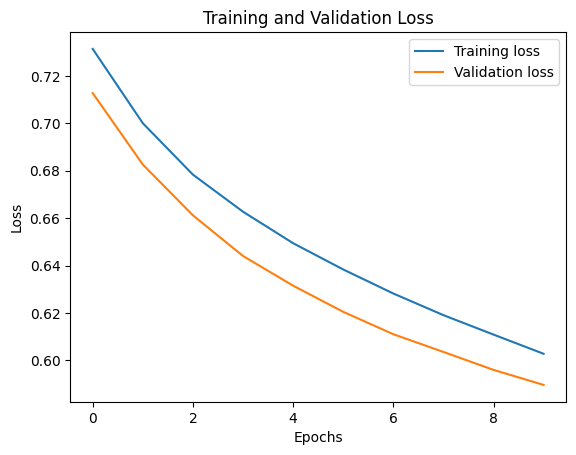

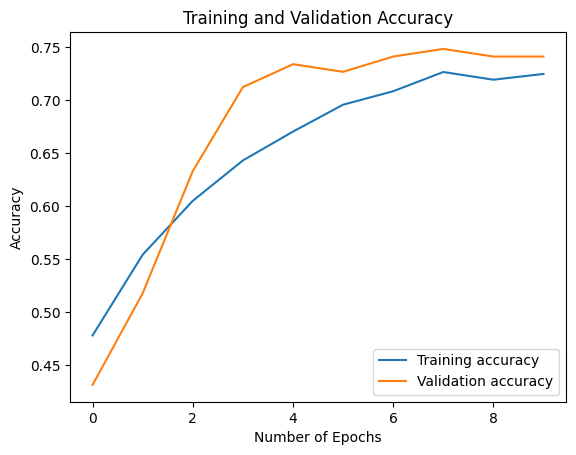

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7412 - loss: 0.6111 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Test Accuracy: 0.7792207598686218, Precision: 0.7873440285204991, Recall: 0.7792207792207793, F1 Score: 0.7633768881475304
SGD oprimizer accuracy: 0.7792207598686218, loss: 0.5963749289512634
------------------------------------------------------------
Training with activation function: RMSprop
Epoch 1/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.6773 - loss: 0.6577 - val_accuracy: 0.7410 - val_loss: 0.6144
Epoch 2/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7365 - loss: 0.6013 - val_accuracy: 0.7410 - val_loss: 0.5710
Epoch 3/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7825 - loss: 0.5451 - val_accuracy: 0.7266 - val_loss: 0.5392
Epoch 4/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8026 - loss: 0.4931 - val_accuracy: 0.7410 - val_loss: 0.5190
Epoch 5/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7944 - loss: 0.4884 - val_accuracy:

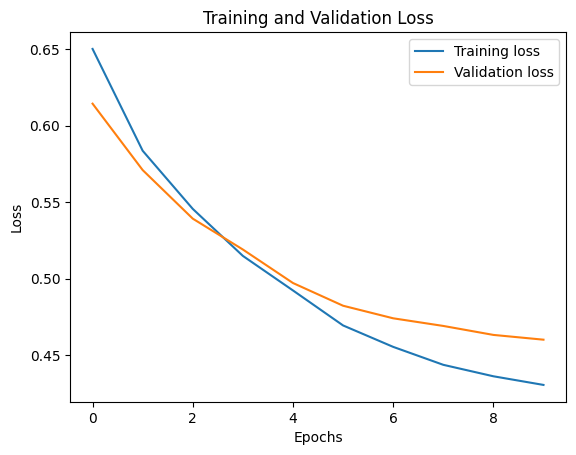

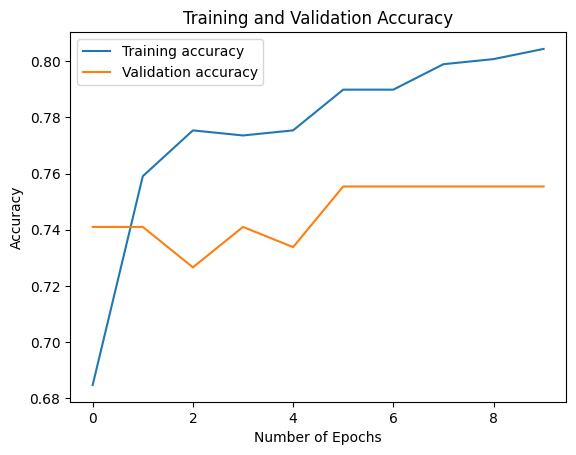

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7672 - loss: 0.5548 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Test Accuracy: 0.7922077775001526, Precision: 0.7900826446280993, Recall: 0.7922077922077922, F1 Score: 0.7857342657342657
RMSprop oprimizer accuracy: 0.7922077775001526, loss: 0.4945181906223297
------------------------------------------------------------
Training with activation function: Adam
Epoch 1/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.5733 - loss: 0.6790 - val_accuracy: 0.7626 - val_loss: 0.6154
Epoch 2/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7339 - loss: 0.6234 - val_accuracy: 0.7770 - val_loss: 0.5680
Epoch 3/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7481 - loss: 0.5558 - val_accuracy: 0.7482 - val_loss: 0.5349
Epoch 4/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7305 - loss: 0.5450 - val_accuracy: 0.7626 - val_loss: 0.5157
Epoch 5/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8093 - loss: 0.4990 - val_accuracy

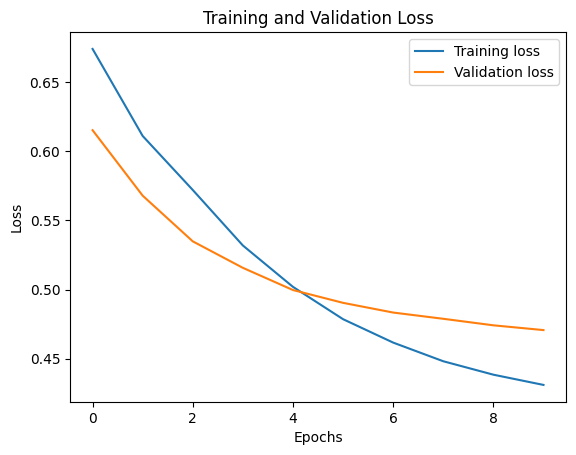

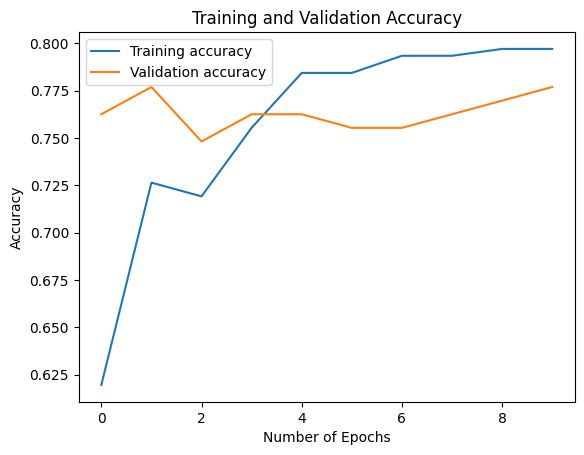

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7412 - loss: 0.5545 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Test Accuracy: 0.7792207598686218, Precision: 0.7755087102913191, Recall: 0.7792207792207793, F1 Score: 0.7737569873492204
Adam oprimizer accuracy: 0.7792207598686218, loss: 0.4930858016014099
------------------------------------------------------------
Training with activation function: Adadelta
Epoch 1/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.6456 - loss: 0.6656 - val_accuracy: 0.6691 - val_loss: 0.6465
Epoch 2/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6279 - loss: 0.6696 - val_accuracy: 0.6691 - val_loss: 0.6464
Epoch 3/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6450 - loss: 0.6606 - val_accuracy: 0.6691 - val_loss: 0.6463
Epoch 4/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6389 - loss: 0.6638 - val_accuracy: 0.6691 - val_loss: 0.6461
Epoch 5/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6499 - loss: 0.6586 - val_accurac

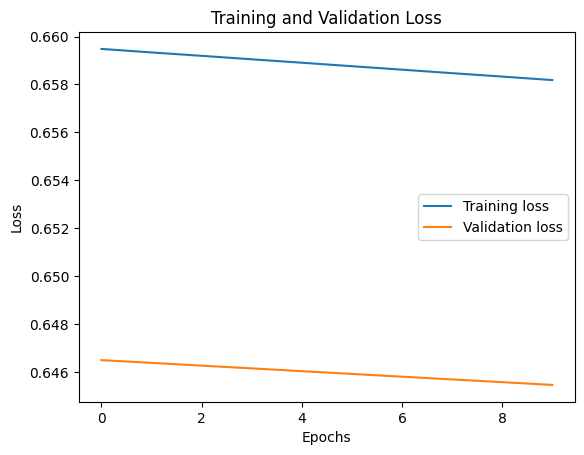

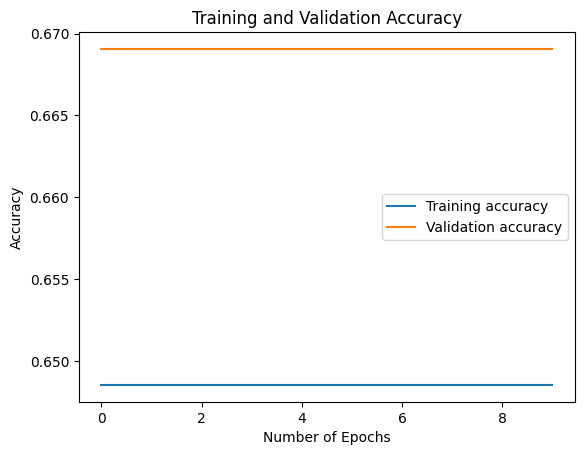

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6307 - loss: 0.6417 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Test Accuracy: 0.6363636255264282, Precision: 0.5941101152368758, Recall: 0.6363636363636364, F1 Score: 0.5520499108734404
Adadelta oprimizer accuracy: 0.6363636255264282, loss: 0.6205635666847229
------------------------------------------------------------
Training with activation function: Adagrad
Epoch 1/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.6288 - loss: 0.6636 - val_accuracy: 0.6475 - val_loss: 0.6503
Epoch 2/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6234 - loss: 0.6685 - val_accuracy: 0.6331 - val_loss: 0.6470
Epoch 3/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6180 - loss: 0.6618 - val_accuracy: 0.6331 - val_loss: 0.6439
Epoch 4/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6293 - loss: 0.6572 - val_accuracy: 0.6475 - val_loss: 0.6411
Epoch 5/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6348 - loss: 0.6490 - val_acc

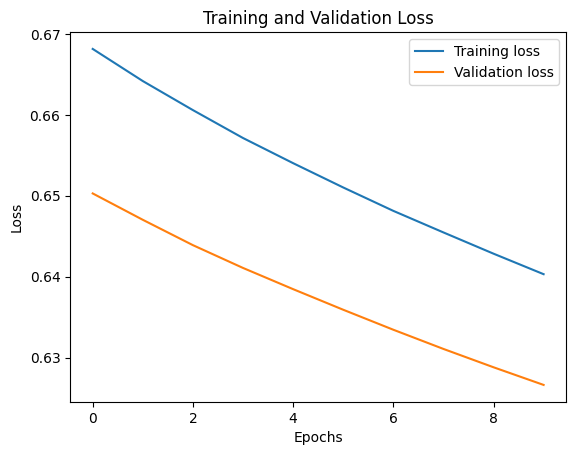

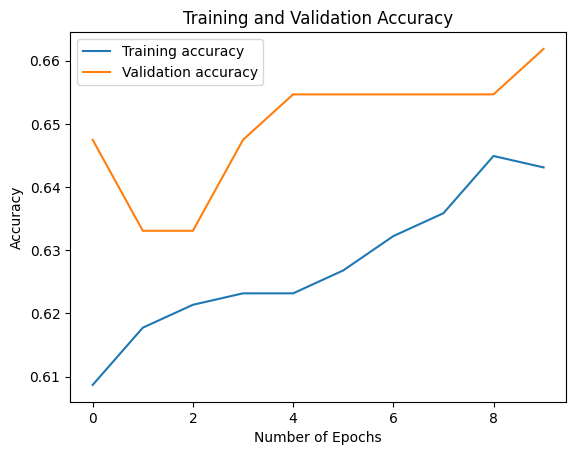

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6606 - loss: 0.6399 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Test Accuracy: 0.649350643157959, Precision: 0.625974025974026, Recall: 0.6493506493506493, F1 Score: 0.5750954927425516
Adagrad oprimizer accuracy: 0.649350643157959, loss: 0.641597330570221
------------------------------------------------------------
Training with activation function: Adamax
Epoch 1/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.4187 - loss: 0.7218 - val_accuracy: 0.6691 - val_loss: 0.6534
Epoch 2/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6804 - loss: 0.6330 - val_accuracy: 0.6835 - val_loss: 0.6076
Epoch 3/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7148 - loss: 0.5778 - val_accuracy: 0.7122 - val_loss: 0.5783
Epoch 4/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7073 - loss: 0.5665 - val_accuracy: 0.7122 - val_loss: 0.5569
Epoch 5/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7323 - loss: 0.5362 - val_accuracy: 

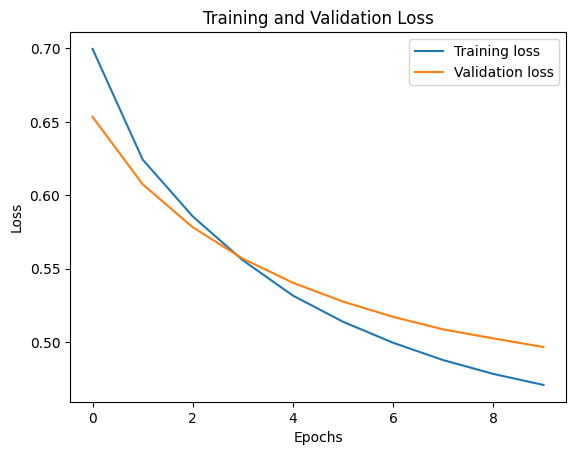

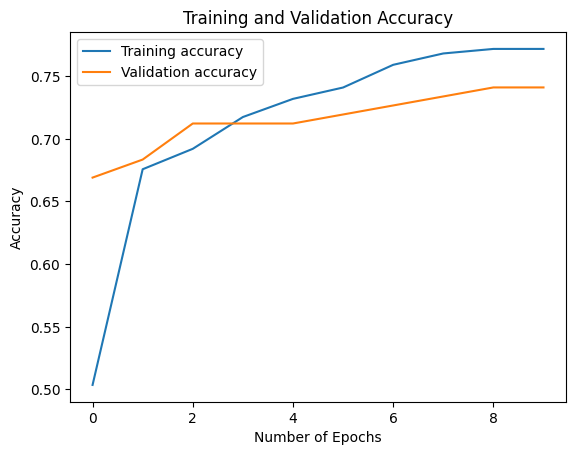

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7412 - loss: 0.5583 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Test Accuracy: 0.7792207598686218, Precision: 0.7755087102913191, Recall: 0.7792207792207793, F1 Score: 0.7737569873492204
Adamax oprimizer accuracy: 0.7792207598686218, loss: 0.5043381452560425
------------------------------------------------------------
Training with activation function: Nadam
Epoch 1/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.6030 - loss: 0.6679 - val_accuracy: 0.7050 - val_loss: 0.6331
Epoch 2/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6623 - loss: 0.6194 - val_accuracy: 0.7050 - val_loss: 0.5900
Epoch 3/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7249 - loss: 0.5649 - val_accuracy: 0.7410 - val_loss: 0.5508
Epoch 4/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7685 - loss: 0.5166 - val_accuracy: 0.7626 - val_loss: 0.5201
Epoch 5/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7640 - loss: 0.4973 - val_accuracy

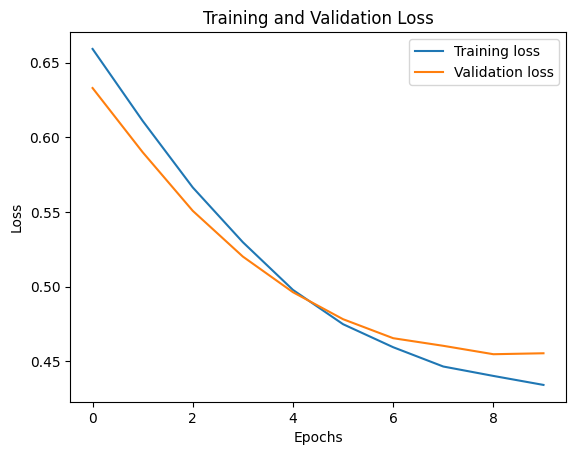

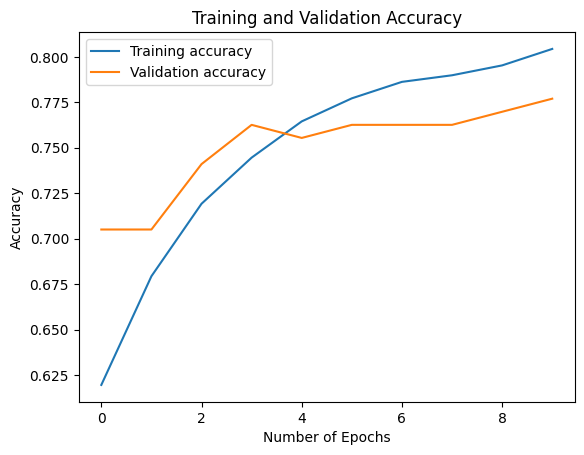

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7126 - loss: 0.5749 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Test Accuracy: 0.7532467246055603, Precision: 0.7479139218269654, Recall: 0.7532467532467533, F1 Score: 0.7471401623314816
Nadam oprimizer accuracy: 0.7532467246055603, loss: 0.5191235542297363


In [24]:
optimizers = ['SGD', 'RMSprop', 'Adam', 'Adadelta', 'Adagrad', 'Adamax', 'Nadam']
histories = {}
optimizers_results = {}
for opt in optimizers:
  print("-" * 60)
  print(f"Training with activation function: {opt}")
  model_instance = DiabetesPredictionModel(optimizer=opt.lower())
  test_loss, val_loss, test_accuracy, precision, recall, f1 = model_instance.run(train_X, train_Y, X_test, Y_test)
  optimizers_results[opt] = {'loss': test_loss, 'accuracy': test_accuracy, 'val_loss': val_loss}
  print(f"{opt} oprimizer accuracy: {test_accuracy}, loss: {test_loss}")

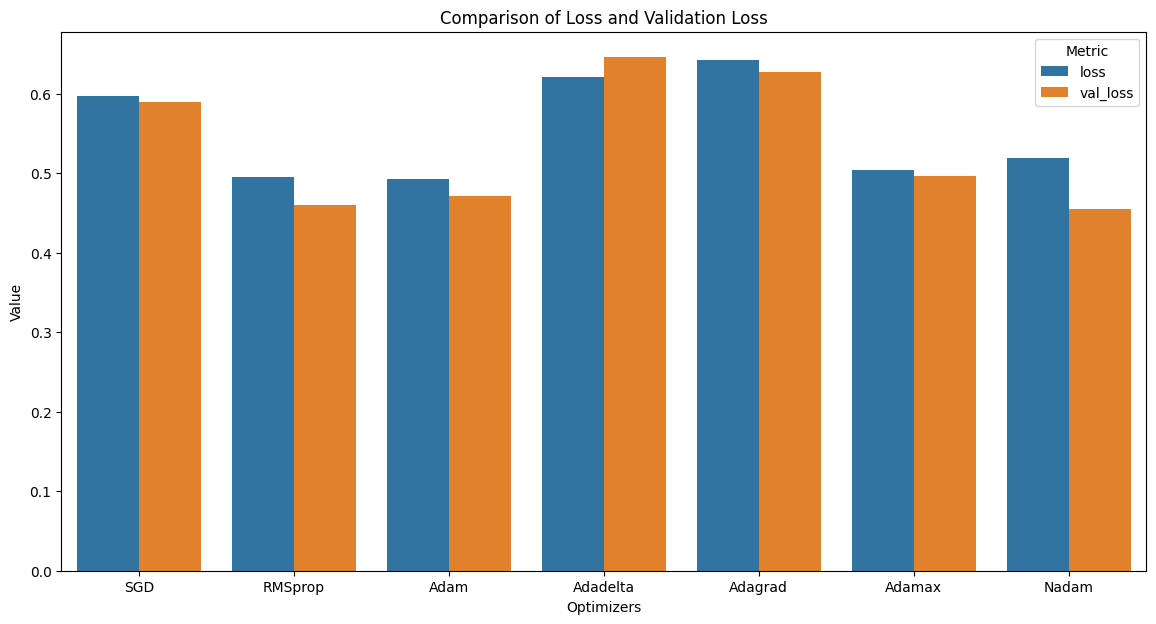

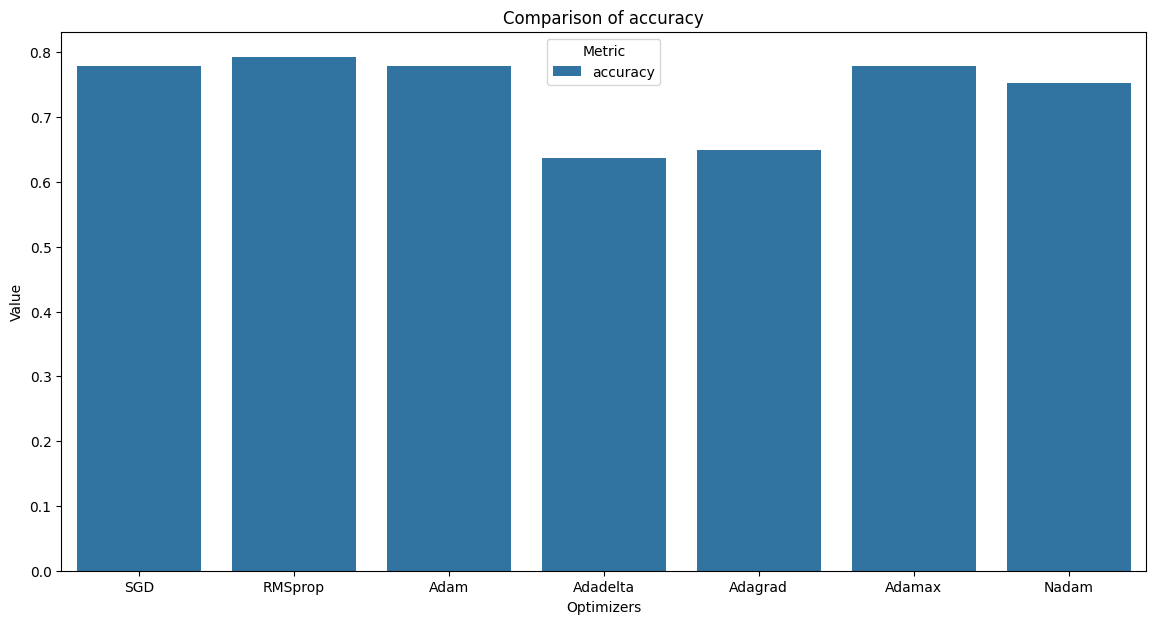

+----+----------------+--------------+--------------+-------+-------------+----------+--------------+------------+-------------+------------+-------------+----------+------------+
|    | architecture   | activation   |   batch_size |    lr | optimizer   |   epochs |   train_loss |   val_loss |   test_loss |   accuracy |   precision |   recall |   f1_score |
+====+================+==============+==============+=======+=============+==========+==============+============+=============+============+=============+==========+============+
|  0 | [64, 32, 16]   | relu         |           64 | 0.001 | adam        |       10 |     0.709481 |   0.726069 |    0.70119  |   0.714286 |    0.737313 | 0.714286 |   0.668784 |
+----+----------------+--------------+--------------+-------+-------------+----------+--------------+------------+-------------+------------+-------------+----------+------------+
|  1 | [64, 32, 16]   | relu         |           64 | 0.001 | adam        |       10 |     0.573553 

In [25]:
plot_results(optimizers_results, "Optimizers")
summarize_results(results)

# Порівняння активаційних функцій

------------------------------------------------------------
Training with activation function: relu
Epoch 1/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.4650 - loss: 0.7048 - val_accuracy: 0.6691 - val_loss: 0.6798
Epoch 2/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6743 - loss: 0.6636 - val_accuracy: 0.6978 - val_loss: 0.6505
Epoch 3/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6901 - loss: 0.6232 - val_accuracy: 0.7194 - val_loss: 0.6123
Epoch 4/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7349 - loss: 0.5793 - val_accuracy: 0.7626 - val_loss: 0.5680
Epoch 5/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7427 - loss: 0.5399 - val_accuracy: 0.7554 - val_loss: 0.5284
Epoch 6/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7640 - loss: 0.4971 - val_accuracy: 0.7482 - val_loss: 0.5093
Epoch 7/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7976 - loss: 0.4405 - val_accuracy: 0.7410 - val_loss: 0.5013
Epoch 8/10
9/9 ━━━━━━━━━━━━━━━

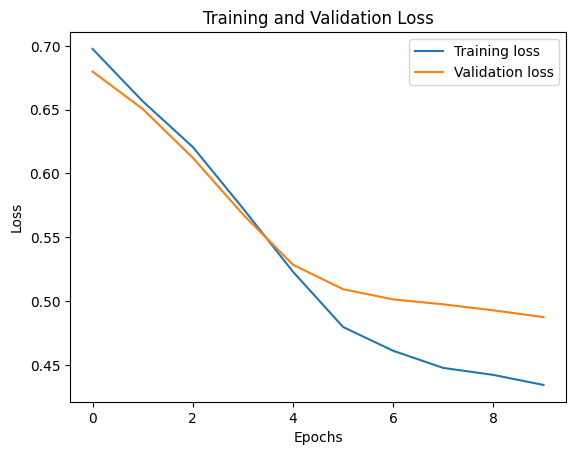

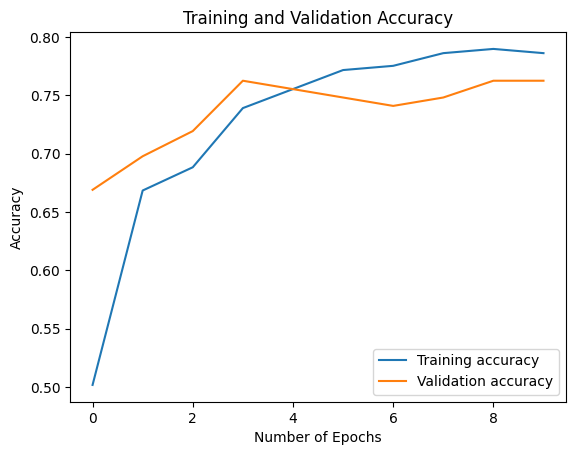

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7308 - loss: 0.5689 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Test Accuracy: 0.7662337422370911, Precision: 0.7618639222412807, Recall: 0.7662337662337663, F1 Score: 0.7618264088852323
relu activation accuracy: 0.7662337422370911, loss: 0.5017393231391907
------------------------------------------------------------
Training with activation function: sigmoid
Epoch 1/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.6253 - loss: 0.6620 - val_accuracy: 0.6835 - val_loss: 0.6272
Epoch 2/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6746 - loss: 0.6302 - val_accuracy: 0.6835 - val_loss: 0.6199
Epoch 3/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6531 - loss: 0.6362 - val_accuracy: 0.6835 - val_loss: 0.6173
Epoch 4/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6533 - loss: 0.6335 - val_accuracy: 0.6835 - val_loss: 0.6163
Epoch 5/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6407 - loss: 0.6363 - val_accura

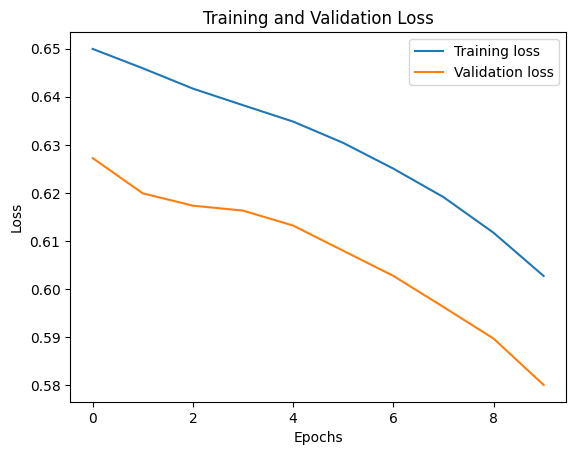

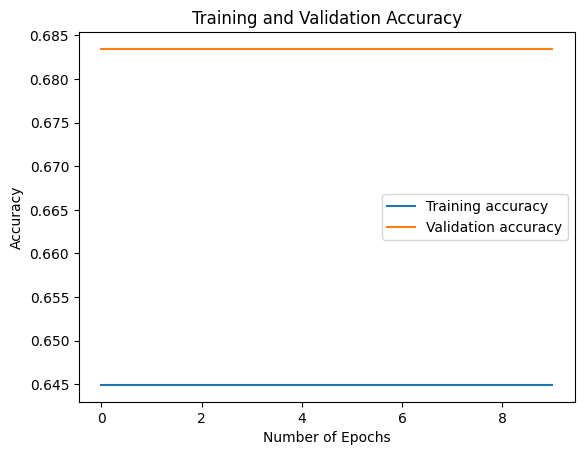

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6229 - loss: 0.6136 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Test Accuracy: 0.6363636255264282, Precision: 0.4049586776859504, Recall: 0.6363636363636364, F1 Score: 0.494949494949495
sigmoid activation accuracy: 0.6363636255264282, loss: 0.5968763828277588
------------------------------------------------------------
Training with activation function: tanh
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.5655 - loss: 0.7248 - val_accuracy: 0.7410 - val_loss: 0.5220
Epoch 2/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7136 - loss: 0.5362 - val_accuracy: 0.7698 - val_loss: 0.4820
Epoch 3/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7494 - loss: 0.5033 - val_accuracy: 0.7626 - val_loss: 0.4748
Epoch 4/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7481 - loss: 0.4724 - val_accuracy: 0.7410 - val_loss: 0.4710
Epoch 5/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7836 - loss: 0.4428 - val_accuracy: 0.7482 - val_loss: 0.4676
Epoch 6/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7691 - loss: 0.4593 - val_accuracy: 0.7698 - val_loss: 0.4600
Epoch 7/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7866 - loss: 0.4547 - val_accuracy: 0.7554 - val_loss: 0.4585
Epoch 8/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8035 - loss: 0.4289 - val_accuracy: 0.7554 - val_loss: 0.4560
Epoch 9/10
9/9 ━━━

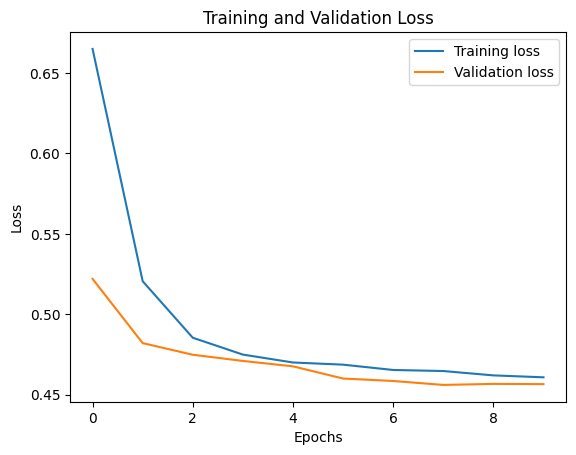

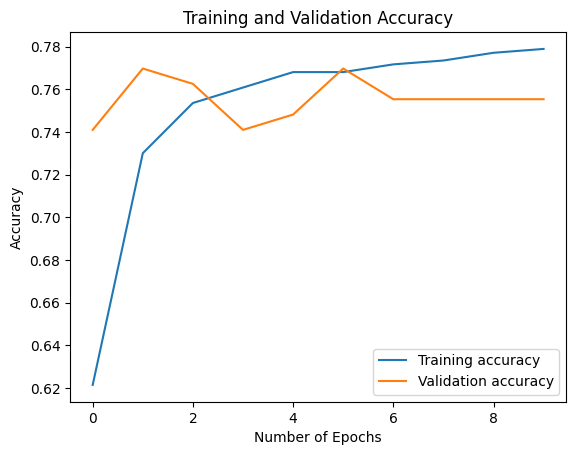

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7412 - loss: 0.5506 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Test Accuracy: 0.7792207598686218, Precision: 0.7755087102913191, Recall: 0.7792207792207793, F1 Score: 0.7737569873492204
tanh activation accuracy: 0.7792207598686218, loss: 0.48816680908203125


In [26]:
activations = ['relu', 'sigmoid', 'tanh']
histories = {}
activation_results = {}
for act in activations:
  print("-" * 60)
  print(f"Training with activation function: {act}")
  model_instance = DiabetesPredictionModel(activation=act)
  test_loss, val_loss, test_accuracy, precision, recall, f1 = model_instance.run(train_X, train_Y, X_test, Y_test)
  activation_results[act] = {'loss': test_loss, 'accuracy': test_accuracy, 'val_loss': val_loss}
  print(f"{act} activation accuracy: {test_accuracy}, loss: {test_loss}")

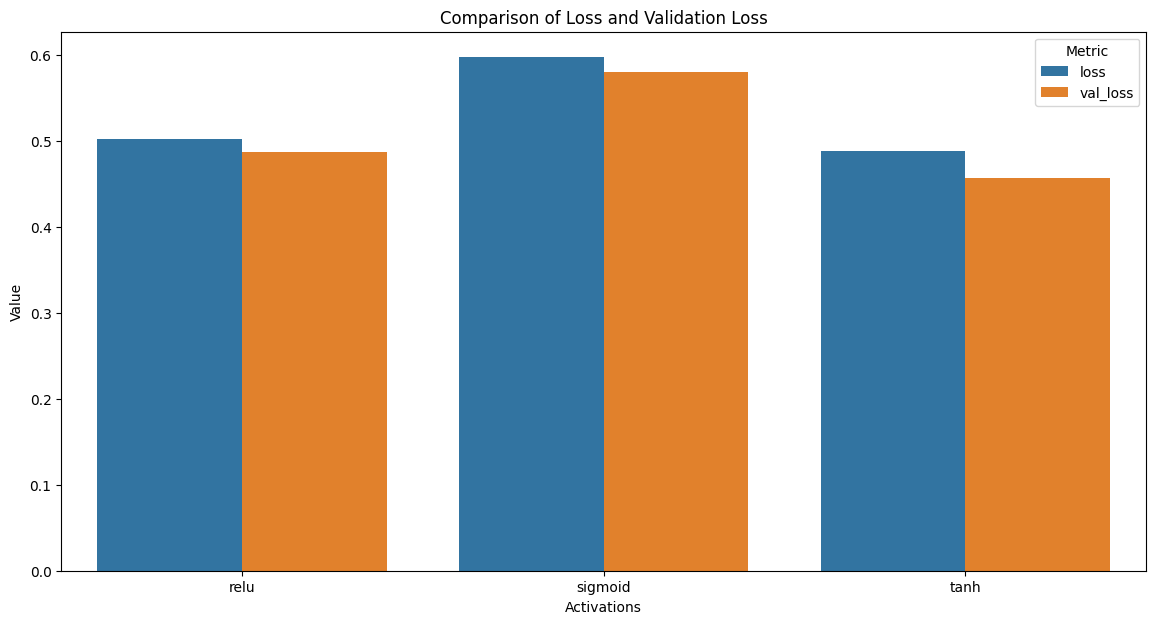

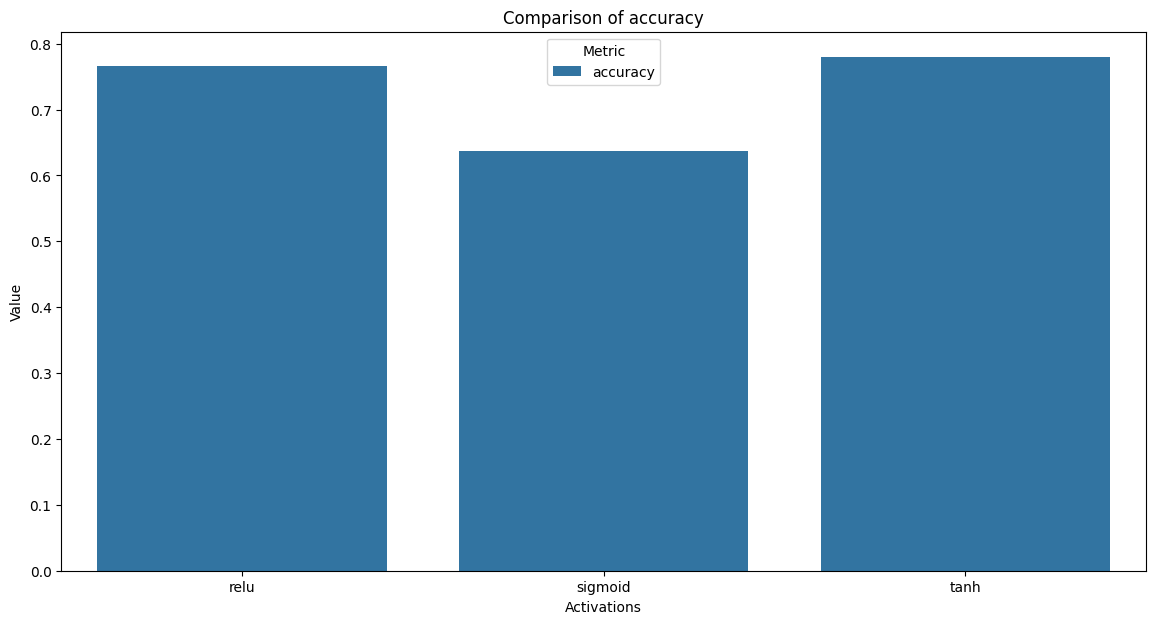

+----+----------------+--------------+--------------+-------+-------------+----------+--------------+------------+-------------+------------+-------------+----------+------------+
|    | architecture   | activation   |   batch_size |    lr | optimizer   |   epochs |   train_loss |   val_loss |   test_loss |   accuracy |   precision |   recall |   f1_score |
+====+================+==============+==============+=======+=============+==========+==============+============+=============+============+=============+==========+============+
|  0 | [64, 32, 16]   | relu         |           64 | 0.001 | adam        |       10 |     0.709481 |   0.726069 |    0.70119  |   0.714286 |    0.737313 | 0.714286 |   0.668784 |
+----+----------------+--------------+--------------+-------+-------------+----------+--------------+------------+-------------+------------+-------------+----------+------------+
|  1 | [64, 32, 16]   | relu         |           64 | 0.001 | adam        |       10 |     0.573553 

In [27]:
plot_results(activation_results, "Activations")
summarize_results(results)